# Northwind database analysis

## Executive Summary 

In [1]:
#imports
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect

import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
import scipy.stats as stats
from sklearn import preprocessing

from datetime import datetime


In [2]:
# create the SQL engine
# optinal - to use the large version of the databse, use this to create the SQL engine:
engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)

# using the small version of the databse:
# engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
con = engine.connect()
Session = sessionmaker(bind=engine)
session = Session()


2019-05-08 10:42:29,160 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-08 10:42:29,162 INFO sqlalchemy.engine.base.Engine ()
2019-05-08 10:42:29,164 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-08 10:42:29,165 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# have a look at the tables
inspector = inspect(engine)
print(inspector.get_table_names())


2019-05-08 10:42:31,010 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-05-08 10:42:31,012 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


There are 13 tables. This chart shows the relationships between the tables.
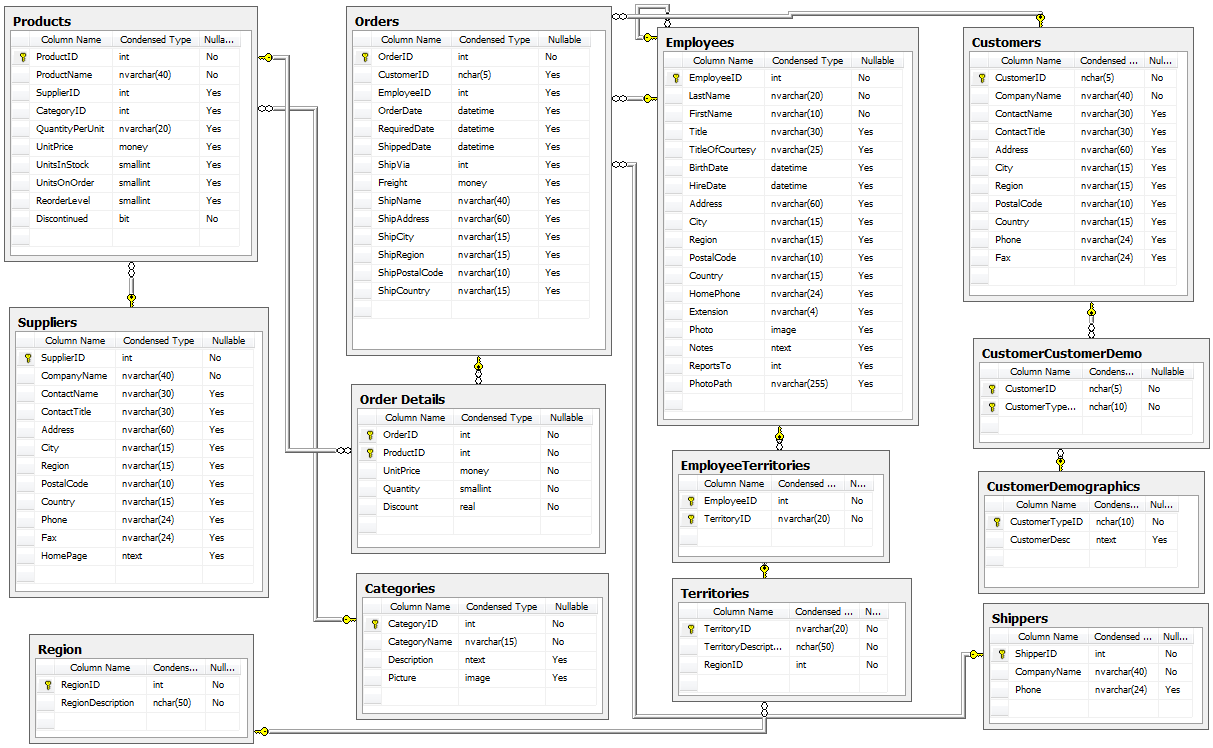

In [4]:
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))

get_columns_info('OrderDetail')

# these are the columns of the OrderDetail table.

2019-05-08 10:42:33,133 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-05-08 10:42:33,135 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT


In [5]:
#function to return a list of the column names from table given as an argument
def make_column_list(table):
    cols = []  #make an empty list
    cols_dict = inspector.get_columns(table)  # make a dict of the column names from the SQL table
#     print(cols_list)
    for column in cols_dict:
        cols.append(column['name'])
#     print(cols)
    return cols


In [6]:
# small sample of order detail for testing
# rs = con.execute('SELECT * FROM OrderDetail LIMIT 25')

# crate a pandas dataframe of the OrderDetail table
rs = con.execute('SELECT * FROM OrderDetail')
order_detail = pd.DataFrame(rs.fetchall())

column_names = make_column_list('OrderDetail')
order_detail.columns = column_names

order_detail.head()

2019-05-08 10:42:37,090 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-05-08 10:42:37,092 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
# customer table to a pandas dataframe
rs = con.execute('SELECT * FROM Customer')
customers = pd.DataFrame(rs.fetchall())
column_names = make_column_list('Customer')
customers.columns = column_names

customers.head(10)


2019-05-08 10:42:43,760 INFO sqlalchemy.engine.base.Engine SELECT * FROM Customer
2019-05-08 10:42:43,762 INFO sqlalchemy.engine.base.Engine ()
2019-05-08 10:42:43,770 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-05-08 10:42:43,771 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745


In [30]:
len(orders)

16818

In [32]:
len(order_detail)

621883

In [29]:
len(customers)

91

In [8]:
# test orders table
# rs = con.execute('SELECT * FROM [Order]')
# orders = pd.DataFrame(rs.fetchall())
# orders.head()


# get full orders
rs = con.execute('SELECT * FROM [Order]')
orders = pd.DataFrame(rs.fetchall())

column_names = make_column_list('Order')
orders.columns = column_names



2019-05-08 10:42:50,146 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-05-08 10:42:50,148 INFO sqlalchemy.engine.base.Engine ()
2019-05-08 10:42:50,277 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-05-08 10:42:50,279 INFO sqlalchemy.engine.base.Engine ()


In [9]:
orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,16.75,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,22.25,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,25.00,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,20.25,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,36.25,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


I discovered some orders that had CustomerId's that did not exist in the Customers table:
* ANTO
* DUMO
* OCEA
* QUEE

Upon inspection of the Customers table, it appears that the above Id's are all missing an "N" at the end of the Id. I chose to assign these orders to the appropriate Customer, assuming the the last letter had somehow been deleted. 

In [10]:
# correct the incorect CustomerId values in orders_count
orders['CustomerId'].replace('ANTO', 'ANTON', inplace=True)
orders['CustomerId'].replace('DUMO', 'DUMON', inplace=True)
orders['CustomerId'].replace('OCEA', 'OCEAN', inplace=True)
orders['CustomerId'].replace('QUEE', 'QUEEN', inplace=True)
orders.sort_values('CustomerId').groupby('CustomerId').groups

{'ALFKI': Int64Index([14812, 16331, 12084, 12031,  7991, 12022, 16294,  8102, 11920,
              8132,
             ...
             15157,  6446,   704,  5755,  1252,  6923, 16520, 13463,  6961,
             14709],
            dtype='int64', length=200),
 'ANATR': Int64Index([ 2462, 11098,   903,  5378,  2082, 10579,  4768, 10176, 10188,
              2488,
             ...
              9978,  2714,  3998,  4623,  6047,  5822,  3967,  3975,  9932,
              9685],
            dtype='int64', length=192),
 'ANTON': Int64Index([ 7365, 12696, 14608,  4290,  9868, 12651,  6577, 12697,  1476,
             12721,
             ...
              6537,  3916,  1715, 11708,  9643, 11923, 11713,  2369,  5331,
             11746],
            dtype='int64', length=198),
 'AROUT': Int64Index([ 3785,  3966,   768,  6048,   946, 14632,  4332, 13779,  3680,
               874,
             ...
             16501, 16198, 16669,   495, 14821,   493,   205, 14948, 15478,
             16072],
    

All CustomerId values in the orders table now appear to be correct.

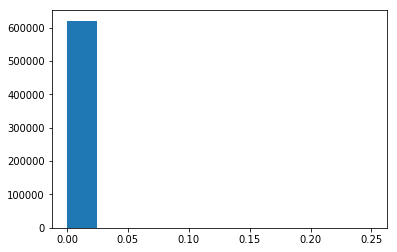

In [11]:
# an initial look at how product line items in the orders are distributed based on any discounts
plt.hist(order_detail["Discount"])
plt.show()

The vast majority of products ordered have no discount.
For ordered products that had a discount applied, the distribution into different levels of discount looks roughly equal.  

In [12]:
# make a new column to calculate the line item total
order_detail['line_total'] = order_detail['Quantity'] * order_detail['UnitPrice'] * (1 - order_detail['Discount'])

order_detail.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


Now I can look at the total $ value of each line item on each order.

In [13]:
order_detail.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount,line_total
count,621883.000000,621883.000000,621883.000000,621883.000000,621883.000000,621883.000000
mean,19028.456026,38.996047,28.893059,25.495974,0.000195,736.259109
std,4624.516464,22.219997,33.640513,14.449898,0.005917,1067.189262
min,10248.000000,1.000000,2.000000,1.000000,0.000000,2.500000
25%,15028.000000,20.000000,13.250000,13.000000,0.000000,216.000000
50%,19018.000000,39.000000,19.500000,25.000000,0.000000,462.000000
75%,23007.000000,58.000000,33.250000,38.000000,0.000000,864.800000
max,27065.000000,77.000000,263.500000,130.000000,0.250000,15810.000000


Idea: Compare orders that contain at least one discounted item to orders that have no discounts.
* Is the average order total higher?
* Is the count of total items ordered higher?
* Is the count of unique products higher?

From prior labs:
q = """SELECT LastName, FirstName, COUNT(*) as TerritoriesAssigned from \
Employee \
JOIN EmployeeTerritory et on Employee.Id = et.employeeId \
GROUP BY Employee.lastname \
ORDER BY TerritoriesAssigned DESC"""

In [14]:
# rs = con.execute('SELECT * FROM [Order] JOIN OrderDetail on Order.OrderID = OrderDetail.OrderID WHERE OrderDetail.Discount > 0')
rs = con.execute('SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0')

orders_with_discount = pd.DataFrame(rs.fetchall())

orders_with_discount.columns = ['Id']

orders_with_discount.count()
# orders_with_discount.head()


2019-05-08 10:43:31,964 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT OrderId FROM OrderDetail WHERE Discount > 0
2019-05-08 10:43:31,966 INFO sqlalchemy.engine.base.Engine ()


Id    380
dtype: int64

380 orders had at least one item discounted on the order.

In [15]:
# make a list of orders that have no discounted items
orders_without_discount = orders.merge(orders_with_discount.drop_duplicates(), on=['Id'], how='left', indicator=True)

orders_without_discount = orders_without_discount[orders_without_discount._merge != 'both']

# orders_without_discount.head()

orders_without_discount.count()

# sources
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe
# https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/

Id                16438
CustomerId        16438
EmployeeId        16438
OrderDate         16438
RequiredDate      16438
ShippedDate       16428
ShipVia           16438
Freight           16438
ShipName          16438
ShipAddress       16438
ShipCity          16438
ShipRegion        16438
ShipPostalCode    16258
ShipCountry       16438
_merge            16438
dtype: int64

In [16]:
orders.count()

Id                16818
CustomerId        16818
EmployeeId        16818
OrderDate         16818
RequiredDate      16818
ShippedDate       16797
ShipVia           16818
Freight           16818
ShipName          16818
ShipAddress       16818
ShipCity          16818
ShipRegion        16818
ShipPostalCode    16623
ShipCountry       16818
dtype: int64

830 orders:
* 450 orders have no discounts on any item
* 380 orders have at least one discounted product in the order.
* 19 orders have no value for ShipPostalCode.
* 21 orders have no value for ShippedDate.

In [17]:
# rs = con.execute('SELECT * FROM OrderDetail JOIN [Order] on OrderDetail.Id = [Order].Id')
# temp_df = pd.DataFrame(rs.fetchall())
# temp_df

Idea - Make a pandas dataframe of all orders where there is any item with a discount. 
Within those orders, what are the summary statistics for:
* The number of different SKU's in the order 
* Quantity of each SKU ordered. How does this compare to orders where the samei SKU has been ordered but there was no discount.
* 

And then compare those statistics to orders where there was no item with a discount.










add these columns to the order dataframe: 
* order_total
* unique_products_count
* all_items_total_qty_count

In [18]:
len(order_detail)

621883

In [19]:
order_detail.head()
print(order_detail.loc[order_detail['OrderId'] == 10248])
# print(df.loc[df['A'] == 'foo'])

         Id  OrderId  ProductId  UnitPrice  Quantity  Discount  line_total
0  10248/11    10248         11       14.0        12       0.0       168.0
1  10248/42    10248         42        9.8        10       0.0        98.0
2  10248/72    10248         72       34.8         5       0.0       174.0


In [20]:
# add blank columns to orders dataframe
orders['order_total'] = 0
orders['unique_products_count'] = 0
orders['all_items_total_qty_count'] = 0
orders['discount_flag'] = False #True if order contains any discounted items, otherwise False

orders.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,16.75,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,0,0,0,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,22.25,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,0,0,0,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,25.00,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,0,0,0,False
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,20.25,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,0,0,0,False
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,36.25,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,0,0,0,False


In [21]:
# get new column values, add to orders dataframe
for index, row in orders.iterrows():
    order_id = row['Id']     #row['Id'] gets the OrderId column value
    order_index =  orders.loc[orders['Id'] == order_id].index   #  order_index:  Int64Index([0], dtype='int64')
    
#     print ("order_id: ", order_id)
#     print ("order_index: ", order_index[0])  
    
# get the relevant rows from order_detail
    temp_df = order_detail.loc[order_detail['OrderId'] == order_id]
#     print(temp_df)
    
    order_total = 0
    order_product_ids_count = 0
    product_ids = []
    all_items_total_qty_count = 0
    discount_flag = False
    for index, row in temp_df.iterrows():
#         print(row)
        #for testing
#         print("UnitPrice: {}, Quantity: {}, Discount: {} ".format(row['UnitPrice'], row['Quantity'], row['Discount']))
        order_total += round((row['UnitPrice'] * row['Quantity']) * (1 - row['Discount']),2)
        #for testing
#     print("order_total: {}".format(order_total))
    
    #get the unique product id's
        product_ids.append(row['ProductId'])
        
    #count up the total # of units of all products in the order
        all_items_total_qty_count += row['Quantity']
        
    #check if any discount
        if discount_flag == False:
            if row['Discount'] > 0:
                discount_flag = True
    
    #make a set (only unique values)
    product_ids = set(product_ids)
    
# add these values to the order in the orders dataframe

#     print("Order {} complete. Order amount: {} - unique items: {} - item count: {}"
#           .format(order_id, order_total, len(product_ids), all_items_total_qty_count))
    
#     orders.iloc[order_index[0],'order_total'] = order_total
#     orders.ix[order_index[0], 'order_total'] = order_total  # .ix has been deprecated
    orders.iloc[order_index[0], orders.columns.get_loc('order_total')] = order_total
    orders.iloc[order_index[0], orders.columns.get_loc('unique_products_count')] = len(product_ids)
    orders.iloc[order_index[0], orders.columns.get_loc('all_items_total_qty_count')] = all_items_total_qty_count
    orders.iloc[order_index[0], orders.columns.get_loc('discount_flag')] = discount_flag
#     print(orders.iloc[order_index[0]])
#     print(orders.loc[orders['Id'] == order_id])
#               df.loc[df['column_name'] == some_value]
    

In [22]:
# make Id the index of orders dataframe
# orders.set_index('Id', inplace=True)

# look at orders
orders.head()



,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,16.75,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.00,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,22.25,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.40,2,49,False
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,25.00,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,20.25,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,36.25,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True


In [23]:
discount = orders[orders['discount_flag'] == True]
discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,25.00,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1552.60,3,60,True
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,20.25,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,654.06,3,41,True
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,36.25,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,3597.90,3,105,True
6,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,24.25,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland,556.62,3,57,True
10,10258,ERNSH,1,2012-07-17,2012-08-14,2012-07-23,1,40.25,Ernst Handel,Kirchgasse 6,Graz,Western Europe,8010,Austria,1614.88,3,121,True


In [24]:
len(discount)

380

In [25]:
# no_discount = orders[orders['Id'].isin(no_discount_list)]
# no_discount.head()

no_discount = orders[orders['discount_flag'] == False]
no_discount.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,16.75,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,440.0,3,27,False
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,22.25,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,1863.4,2,49,False
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,35.50,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,1444.8,3,102,False
7,10255,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,37.50,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,2490.5,4,110,False
8,10256,WELLI,3,2012-07-15,2012-08-12,2012-07-17,2,16.75,Wellington Importadora,"Rua do Mercado, 12",Resende,South America,08737-363,Brazil,517.8,2,27,False


In [26]:
len(no_discount)

16438

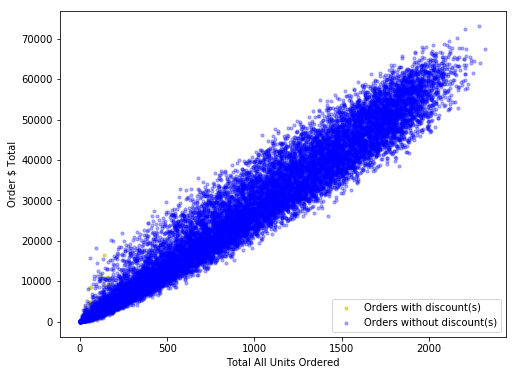

In [27]:
#original
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['all_items_total_qty_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['all_items_total_qty_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Total All Units Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='lower right')


It looks like orders with at least one discounted item tend to have a higher total # of units ordered.

In [28]:
customers.describe()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
count,91,91,91,91,91,91,91,90,91,91,69
unique,91,91,91,12,91,69,9,86,21,91,69
top,ANTON,Victuailles en stock,Yoshi Latimer,Sales Representative,Maubelstr. 90,London,Western Europe,1010,USA,035-640230,26.47.15.11
freq,1,1,1,17,1,6,28,3,13,1,1


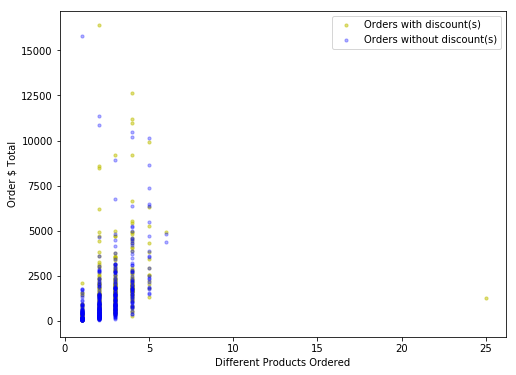

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['order_total'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['order_total'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Order $ Total")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

This graph does not show much of a relationship between the number of different products orderd and the total value of the order.

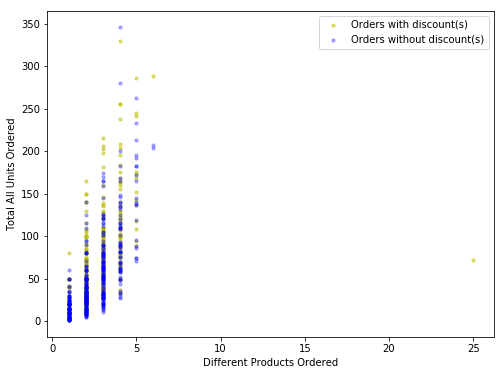

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(discount['unique_products_count'], discount['all_items_total_qty_count'], s=10, c='y', alpha=.5, label='Orders with discount(s)')
ax.scatter(no_discount['unique_products_count'], no_discount['all_items_total_qty_count'], s=10, c='b', alpha=.3, label='Orders without discount(s)')
ax.set_xlabel("Different Products Ordered")
ax.set_ylabel("Total All Units Ordered")
plt.legend(loc='upper right')


#redu this plot to make a better visualization

This graph does not show much of a relationship between the number of different products orderd and the total units of products ordered.

Next Steps:
* create totals for each customer:
    * total number of orders
    * total $ value of all orders
    * first order date
    * last order date
    * average orders/month (year?, etc.)
    






In [30]:
# add columns to customer dataframe: orders_count, orders_value, first_order_date, last_order_date
customers['orders_count'] = 0
customers['orders_value'] = 0
customers['first_order_date'] = 0
customers['last_order_date'] = 0

# cast date columns as pandas datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers.head()


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,0,0,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,0,0,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,0,0,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,0,0,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,0,0,1970-01-01,1970-01-01


In [31]:
#get orders count
orders_count = orders.groupby("CustomerId")["Id"].nunique()
orders_count.head(10)

CustomerId
ALFKI     6
ANATR     4
ANTON     7
AROUT    13
BERGS    18
BLAUS     7
BLONP    11
BOLID     3
BONAP    17
BOTTM    14
Name: Id, dtype: int64

In [32]:
orders_count = orders_count.reset_index()
# orders_count.describe()
orders_count.head(10)

,CustomerId,Id
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18
5,BLAUS,7
6,BLONP,11
7,BOLID,3
8,BONAP,17
9,BOTTM,14


In [33]:
# data.rename(columns={'gdp':'log(gdp)'}, inplace=True)
orders_count.rename(columns={'Id':'order_count'}, inplace=True)

In [34]:
orders_count.head()

,CustomerId,order_count
0,ALFKI,6
1,ANATR,4
2,ANTON,7
3,AROUT,13
4,BERGS,18


In [35]:
orders_count.describe()

,order_count
count,89.000000
mean,9.325843
std,5.810991
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,31.000000


/Users/giovanni/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of the Number of Orders per Customer')

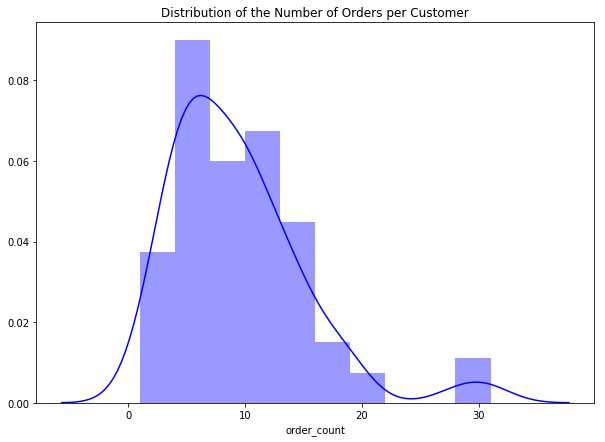

In [36]:
plt.figure(figsize=(10,7))

sns.distplot(orders_count['order_count'], color="blue",)
plt.title("Distribution of the Number of Orders per Customer")

In [37]:
# add order count to each customer record

for index, row in orders_count.iterrows():
#     print(row['CustomerId'])
#     print(row['order_count'])
#     break
    customer_id = row['CustomerId']
    order_count = row['order_count']
    customer_index = "NONE"
    
    # all customer id's in the customer table had five digits
    # this if/else statement was used to identify orders where the customer id was not five digits long
    if len(customer_id) == 5:                               
        customer_index = customers.loc[customers['Id'] == customer_id].index
        customers.iloc[customer_index, customers.columns.get_loc('orders_count')] = order_count
    else:
        print('CustomerId: {}'.format(customer_id))
        print('Order Count: {}'.format(order_count))
        print('Customer Index: {}'.format(customer_index))
        

    

In [38]:
#calculate customers total value of all orders
orders_total = orders.groupby("CustomerId")['order_total'].agg(sum)

orders_total = orders_total.reset_index()
orders_total.head()

,CustomerId,order_total
0,ALFKI,4273.00
1,ANATR,1402.95
2,ANTON,7023.98
3,AROUT,13390.65
4,BERGS,24927.58


In [39]:
# add the total value of all orders to each customer
for index, row in orders_total.iterrows():
    customer_id = row['CustomerId']
    order_total = row['order_total']
    customer_index = customers.loc[customers['Id'] == customer_id].index
    customers.iloc[customer_index,customers.columns.get_loc('orders_value')] = order_total

In [40]:
customers.head(10)

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,1970-01-01,1970-01-01
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745,4,1402.95,1970-01-01,1970-01-01
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None,7,7023.98,1970-01-01,1970-01-01
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750,13,13390.65,1970-01-01,1970-01-01
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67,18,24927.58,1970-01-01,1970-01-01
5,BLAUS,Blauer See Delikatessen,Hanna Moos,Sales Representative,Forsterstr. 57,Mannheim,Western Europe,68306,Germany,0621-08460,0621-08924,7,3239.80,1970-01-01,1970-01-01
6,BLONP,Blondesddsl père et fils,Frédérique Citeaux,Marketing Manager,"24, place Kléber",Strasbourg,Western Europe,67000,France,88.60.15.31,88.60.15.32,11,18534.08,1970-01-01,1970-01-01
7,BOLID,Bólido Comidas preparadas,Martín Sommer,Owner,"C/ Araquil, 67",Madrid,Southern Europe,28023,Spain,(91) 555 22 82,(91) 555 91 99,3,4232.85,1970-01-01,1970-01-01
8,BONAP,Bon app,Laurence Lebihan,Owner,"12, rue des Bouchers",Marseille,Western Europe,13008,France,91.24.45.40,91.24.45.41,17,21963.24,1970-01-01,1970-01-01
9,BOTTM,Bottom-Dollar Markets,Elizabeth Lincoln,Accounting Manager,23 Tsawassen Blvd.,Tsawassen,North America,T2F 8M4,Canada,(604) 555-4729,(604) 555-3745,14,20801.59,1970-01-01,1970-01-01


In [41]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [42]:
# inspect the count of orders for customers

order_counts = customers.groupby('orders_count')['orders_count'].count()
order_counts
# order_counts = order_counts.reset_index()

orders_count
0      2
1      1
2      2
3      7
4      6
5     10
6      8
7      7
8      4
9      5
10    11
11     4
12     3
13     3
14     6
15     3
17     1
18     3
19     2
28     1
30     1
31     1
Name: orders_count, dtype: int64

Two customers have no order, one customer has only one order.

In [43]:
under_two_orders = customers.loc[customers['orders_count'] < 2]
print (under_two_orders)

       Id                           CompanyName      ContactName  \
12  CENTC            Centro comercial Moctezuma  Francisco Chang   
21  FISSA  FISSA Fabrica Inter. Salchichas S.A.       Diego Roel   
56  PARIS                     Paris spécialités   Marie Bertrand   

          ContactTitle                  Address         City           Region  \
12   Marketing Manager  Sierras de Granada 9993  México D.F.  Central America   
21  Accounting Manager       C/ Moralzarzal, 86       Madrid  Southern Europe   
56               Owner  265, boulevard Charonne        Paris   Western Europe   

   PostalCode Country            Phone              Fax  orders_count  \
12      05022  Mexico     (5) 555-3392     (5) 555-7293             1   
21      28034   Spain   (91) 555 94 44   (91) 555 55 93             0   
56      75012  France  (1) 42.34.22.66  (1) 42.34.22.77             0   

    orders_value first_order_date last_order_date  
12         100.8       1970-01-01      1970-01-01  
21   

In [44]:
one_order = orders.loc[orders['CustomerId'] == 'CENTC']
one_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag
11,10259,CENTC,4,2012-07-18,2012-08-15,2012-07-25,3,3.25,Centro comercial Moctezuma,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,100.8,2,11,False


In [45]:
one_order_customer = customers.loc[customers['Id'] == "CENTC"]
one_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
12,CENTC,Centro comercial Moctezuma,Francisco Chang,Marketing Manager,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico,(5) 555-3392,(5) 555-7293,1,100.8,1970-01-01,1970-01-01


In [46]:
no_order = orders.loc[orders['CustomerId'] == 'FISSA']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [47]:
no_order = orders.loc[orders['CustomerId'] == 'PARIS']
no_order

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,order_total,unique_products_count,all_items_total_qty_count,discount_flag


In [48]:
# no_order_customer = customers.loc[customers['order_total'] == 0]  #ask why this doesn't work
no_order_customer = customers.loc[customers['Id'] == 'FISSA']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
21,FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel,Accounting Manager,"C/ Moralzarzal, 86",Madrid,Southern Europe,28034,Spain,(91) 555 94 44,(91) 555 55 93,0,0.0,1970-01-01,1970-01-01


In [49]:
no_order_customer = customers.loc[customers['Id'] == 'PARIS']

no_order_customer

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date
56,PARIS,Paris spécialités,Marie Bertrand,Owner,"265, boulevard Charonne",Paris,Western Europe,75012,France,(1) 42.34.22.66,(1) 42.34.22.77,0,0.0,1970-01-01,1970-01-01


In [50]:
#get first and last order dates
# order_dates = orders.groupby("CustomerId")['OrderDate']

for index, row in customers.iterrows():
    #iterrate through customers list
    #set first and last order date variables, cast as time_date
    first_order_date = np.NaN
    last_order_date = np.NaN
    first_order_date = pd.to_datetime(first_order_date)
    last_order_date = pd.to_datetime(last_order_date)

    # get current customer id
    customer_id = row['Id']
    temp_list = []
    # iterrate through orders
    for index, row in orders.iterrows():
        if row['CustomerId'] == customer_id:
            temp_list.append(row['OrderDate'])
#     print(temp_list)
    temp_list.sort()
    customer_index = customers.loc[customers['Id'] == customer_id].index
    
    if len(temp_list) == 0: #flag to see if any customers have no orders
        print('No order found for customer: {}'.format(customer_id))
        
    if len(temp_list) == 1: #handle the case where there is only one order
        print('Customer: {} has only one order.'.format(customer_id))
        temp_date = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_date
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_date
        
    if temp_list: # case there there is more than one order
        customers.iloc[customer_index, customers.columns.get_loc('first_order_date')] = temp_list.pop(0)
        customers.iloc[customer_index, customers.columns.get_loc('last_order_date')] = temp_list.pop(-1)
    

Customer: CENTC has only one order.
No order found for customer: FISSA
No order found for customer: PARIS


In [51]:
customers.describe()

,orders_count,orders_value
count,91.000000,91.000000
mean,9.120879,13909.813297
std,5.908253,20103.531743
min,0.000000,0.000000
25%,5.000000,3166.755000
50%,8.000000,7023.980000
75%,12.000000,16646.830000
max,31.000000,110277.320000


In [52]:
# create some columns: average value of each customers orders, age of customer
# cast date columns as datetime
customers['first_order_date'] = pd.to_datetime(customers['first_order_date'])
customers['last_order_date'] = pd.to_datetime(customers['last_order_date'])

customers['order_avg'] = customers['orders_value'] / customers['orders_count']
today = pd.to_datetime('today')
customers['scaled_customer_age'] = (today - customers['first_order_date']).dt.days

customers.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,1925
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,2003
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,2059
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,2082
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,2100
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,2108
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,2143
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,2149
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,2192
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,2193


In [54]:
# drop the customers that have no orders
# df[df.name != 'Tina']

customers = customers[customers.orders_count != 0]
customers.sort_values(['scaled_customer_age'])


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,1925
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,2003
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,2059
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,2082
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,2100
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,2108
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,2143
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,2149
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,2192
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,2193


In [55]:
# normalize customer_age
x = customers[['scaled_customer_age']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

customers['scaled_customer_age'] = x_scaled


# https://chrisalbon.com/python/data_wrangling/pandas_normalize_column/

In [56]:
# customers.drop('customer_age', axis=1, inplace=True)

In [58]:
customers.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,0.000000
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,0.135889
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,0.233449
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.273519
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,0.304878
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,0.318815
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,0.379791
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,0.390244
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,0.465157
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,0.466899


(array([ 1.,  1.,  2.,  4.,  4.,  3.,  7., 16., 17., 34.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

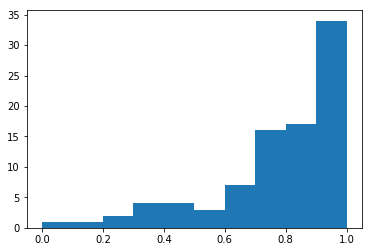

In [59]:
plt.hist(customers.scaled_customer_age)

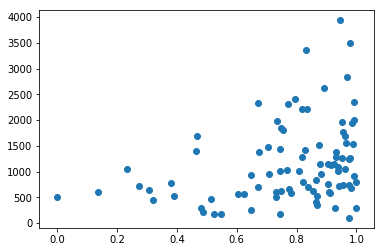

In [60]:
plt.scatter(customers.scaled_customer_age, customers.order_avg)

Hypothesis test 2 

Ho = There is no difference between the average order total of older customers and more recent customers.

Ha = Older customers have a higher average order total.


In [76]:
# funciton to create a ramdom sample of size n from a list

def create_samples(list_of_values, n):
    full_list = []
    while len(full_list) < n:
        random_sample = np.random.choice(list_of_values)
        full_list.append(random_sample)
    return full_list

def create_distribution_of_sample_means(list_of_values, distribution_size, n):
    sample_means = []
    while len(sample_means) < distribution_size:
        sample = create_samples(list_of_values, n)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)
#         print("Sample mean # {} done.".format(len(sample_means)))
    return sample_means


In [61]:
# split customers into two groups, youngest 75%, oldest 25% 
# determine the level at which to split the groups
customers.describe()


,orders_count,orders_value,order_avg,scaled_customer_age
count,89.000000,89.000000,89.000000,89.000000
mean,9.325843,14222.393371,1159.171682,0.775300
std,5.810991,20219.819625,782.064501,0.218891
min,1.000000,100.800000,100.800000,0.000000
25%,5.000000,3239.800000,608.990000,0.705575
50%,8.000000,7048.240000,1003.425714,0.834495
75%,12.000000,16817.100000,1517.747000,0.940767
max,31.000000,110277.320000,3938.475714,1.000000


In [62]:
# scaled customer age of .9407 and higher will give me the oldest 25%
# df['elderly'] = np.where(df['age']>=50, 'yes', 'no')
customers['oldest_25pct'] = np.where(customers['scaled_customer_age'] >= .9407, True, False)
customers.sort_values(['scaled_customer_age'])

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,orders_count,orders_value,first_order_date,last_order_date,order_avg,scaled_customer_age,oldest_25pct
39,LACOR,La corne d'abondance,Daniel Tonini,Sales Representative,"67, avenue de l'Europe",Versailles,Western Europe,78000,France,30.59.84.10,30.59.85.11,4,1992.05,2014-01-29,2014-03-24,498.012500,0.000000,False
73,SPECD,Spécialités du monde,Dominique Perrier,Marketing Manager,"25, rue Lauriston",Paris,Western Europe,75016,France,(1) 47.55.60.10,(1) 47.55.60.20,4,2423.35,2013-11-12,2014-04-22,605.837500,0.135889,False
25,FRANR,France restauration,Carine Schmitt,Marketing Manager,"54, rue Royale",Nantes,Western Europe,44000,France,40.32.21.21,40.32.21.20,3,3172.16,2013-09-17,2014-03-24,1057.386667,0.233449,False
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545,6,4273.00,2013-08-25,2014-04-09,712.166667,0.273519,False
77,THECR,The Cracker Box,Liu Wong,Marketing Assistant,55 Grizzly Peak Rd.,Butte,North America,59801,USA,(406) 555-5834,(406) 555-8083,3,1947.24,2013-08-07,2014-04-06,649.080000,0.304878,False
89,WILMK,Wilman Kala,Matti Karttunen,Owner/Marketing Assistant,Keskuskatu 45,Helsinki,Scandinavia,21240,Finland,90-224 8858,90-224 8858,7,3161.35,2013-07-30,2014-04-07,451.621429,0.318815,False
44,LETSS,Let's Stop N Shop,Jaime Yorres,Owner,87 Polk St. Suite 5,San Francisco,North America,94117,USA,(415) 555-5938,None,4,3076.47,2013-06-25,2014-02-12,769.117500,0.379791,False
81,TRAIH,Trail's Head Gourmet Provisioners,Helvetius Nagy,Sales Associate,722 DaVinci Blvd.,Kirkland,North America,98034,USA,(206) 555-8257,(206) 555-2174,3,1571.20,2013-06-19,2014-01-08,523.733333,0.390244,False
49,MAISD,Maison Dewey,Catherine Dewey,Sales Agent,Rue Joseph-Bens 532,Bruxelles,Western Europe,B-1180,Belgium,(02) 201 24 67,(02) 201 24 68,7,9736.07,2013-05-07,2014-04-07,1390.867143,0.465157,False
31,GREAL,Great Lakes Food Market,Howard Snyder,Marketing Manager,2732 Baker Blvd.,Eugene,North America,97403,USA,(503) 555-7555,None,11,18507.46,2013-05-06,2014-04-30,1682.496364,0.466899,False


In [74]:
# create the list of sample means from both groups using 5 random samples of size 30

control = customers[customers['oldest_25pct'] == False]
treatment = customers[customers['oldest_25pct'] == True]


In [111]:
control_sample_means = create_distribution_of_sample_means(control['order_avg'], 5, 30)
treatment_sample_means = create_distribution_of_sample_means(treatment['order_avg'], 5, 30)



In [112]:
control_sample_means

[1297.760337724787,
 877.7908567580567,
 997.4026631394751,
 1008.5035325494824,
 941.0967974514593]

In [113]:
treatment_sample_means

[1333.730492977393,
 1323.5797274651275,
 1399.7653290043286,
 1660.8062592390065,
 1249.0950237892714]

In [114]:
# use stats built-in t-test
stats.ttest_ind(control_sample_means, treatment_sample_means, equal_var=False)

Ttest_indResult(statistic=-3.6440536269516612, pvalue=0.006553402985092587)

because there are so few customers, hypothesis testing using sampling seems unlikely.


In [ ]:
# temp = customers.sort_values(by=['order_avg'])  # not working as intended
# temp.describe()

In [ ]:
# sample histogram
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
#graph of average order amount, discounted vs. not discounted

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(discount['order_total'], alpha=.5, label='Orders with discount(s)')
ax.hist(no_discount['order_total'], alpha=.5, label='Orders without discount(s)')
ax.set_xlabel("Order Total")
ax.set_ylabel("$")
plt.legend(loc='upper right')

In [ ]:
#try box plots
data = pd.concat([orders['order_total'], orders['discount_flag']], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
# fig = sns.boxplot(x='discount_flag', y='order_total', data=data, orient='h')  #???
fig = sns.boxplot(x='discount_flag', y='order_total', data=data)
plt.show()


In [ ]:
# discount.head()
orders.head()

As we said previously, scientific experiments actually have 2 hypotheses:


Null Hypothesis: There is no relationship between A and B Example: "There is no relationship between this flu medication and a reduced recovery time from the flu".

The Null Hypothesis is usually denoted as  HOHO 
Alternative Hypothesis: The hypothesis we traditionally think of when thikning of a hypothesis for an experiment Example: "This flu medication reduces recovery time for the flu."

The Alternative Hypothesis is usually denoted as  HaHa 
P-Values and Alpha Values
No matter what you're experimenting on, good experiments come down down to one question: Is our p-value less than our alpha value? Let's dive into what each of these values represents, and why they're so important to experimental design.

P-value: The calculated probability of arriving at this data randomly.

If we calculate a p-value and it comes out to 0.03, we can interpret this as saying "There is a 3% chance that the results I'm seeing are actually due to randomness or pure luck".

αα  (alpha value): The marginal threshold at which we're okay with with rejecting the null hypothesis.

An alpha value can be any value we set between 0 and 1. However, the most common alpha value in science is 0.05 (although this is somewhat of a controversial topic in the scientific community, currently).

If we set an alpha value of  α=0.05α=0.05 , we're essentially saying "I'm okay with accepting my alternative hypothesis as true if there is less than a 5% chance that the results that I'm seeing are actually due to randomness".





In [ ]:
# run a hypothesis test comparing orders with discount to those without
# select multiple samples of the orders and look at the distribution of the sample means

no_discount['order_total'].describe()

In [ ]:
no_discount['order_total'].hist()

In [ ]:
''' Random sampling - Random n rows '''
# no_discount_sample = no_discount['order_total'].sample(n=30)
# # print(no_discount_sample)
# no_discount_sample.describe()

# http://www.datasciencemadesimple.com/random-sampling-pandas-python-2/

In [ ]:
discount['order_total'].describe()

In [ ]:
discount['order_total'].hist()

In [ ]:
# discount_sample = discount['order_total'].sample(n=30)
# discount_sample.describe()

In [ ]:
# create fields for total # of orders, # of orders with a discount, percentage of orders with a discount
# run a hypohtesis test comparing customers with discount vs. no discount, for average value of that customers orders

# calculate the mean and standard deviation for orders with no discount and orders with a discount
# 


# Ho = There is no difference between average order total of orders with any discount(s) and orders with at 
#  least one item discounte.
# Ha = Orders with at least one discounted item have a higher average order total than orders without any discouts.

# alpha = 0.05 . This is the threshold for the p-value that I will use to accept the Ha. If there is a 
# 5% or less probability of obtaining the order total average from the orders with a discount. 
# If the average order total
# for the orders with a total is only 5% likely to be obtained from the samples of the orders with a discount I 
# will 


# mu_2 = the mean order value for orders with a discounted item
# mu_2 = discount.mean()




In [ ]:
# create the list of sample means from both groups using 20 random samples of size 30
discount_sample_means = create_distribution_of_sample_means(discount['order_total'], 20, 30)
no_discount_sample_means = create_distribution_of_sample_means(no_discount['order_total'], 20, 30)

# calculate the control mean & standard deviation
mu = np.mean(no_discount_sample_means)
sigma = np.std(no_discount_sample_means)

# calculate the treatment mean and number of samples
x_bar = np.mean(discount_sample_means)
n = len(discount_sample_means)

# calculate z-score
z = (x_bar - mu) / (sigma/sqrt(n))

# calcule P-value
p = 1 - stats.norm.cdf(z)


In [ ]:
print('Z-score: {:.4f}'.format(z))
print("P-value: {:.12f}".format(p))


In [ ]:
# use stats built-in t-test
stats.ttest_ind(no_discount_sample_means, discount_sample_means, equal_var=False)


The very small P-value indicates that it is extremely unlikely that the mean order total from the discounted orders would be randomly obtained from the non-discounted orders. The null hypothesis can be rejected.


In [ ]:
# start here
# need to calculate cohens d - (effect size), confidence interval, etc. ???


In [ ]:
print("discount_sample_means mean:", np.mean(discount_sample_means))
print("discount_sample_means sigma:", np.std(discount_sample_means))
print("--------")
print("no_discount_sample_means mean:", np.mean(no_discount_sample_means))
print("no_discount_sample_means sigma:", np.std(no_discount_sample_means))

In [ ]:
# check how "normal" the distribution of the set of samples is for both groups
print("Normality test of Samples from Non-Discounted Orders:")
print(stats.normaltest(no_discount_sample_means))
print("----")
print("Normality test of Samples from Discounted Orders:")
print(stats.normaltest(discount_sample_means))

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(no_discount_sample_means, color="blue", label="orders with no discount")
sns.distplot(discount_sample_means, color="orange", label='orders with > 0 discounted items')
plt.legend()


In [ ]:
# trying to understand kurtosis test
uniform = list(range(100))
stats.kurtosistest(uniform)


In [ ]:
# normal test on the uniform dist
stats.normaltest(uniform)

In [ ]:
s = np.random.normal(0, 1, 1000)
plt.hist(s)

In [ ]:
stats.kurtosistest(s)

In [ ]:
stats.normaltest(s)

In [ ]:
# My analyis above can be for a second question: "Do discounts result in bigger # value orders?"
# I didn't really answer the first question
# Do discounts have a statistically significant effect on the number of products customers order?
# If so, at what level(s) of discount?

# Additinal questions:
# Is the age of customers related to how many different products they have ordered?
# Is the age of customers related to how large their orders are. ie., does average order size increase over time?


In [ ]:
# answering question #1:
# pull 

In [ ]:
order_detail.head()

In [ ]:
# create a dataframe to look at the average quantity of each product ordered by the discount
mean_quantity_per_discount = pd.DataFrame(order_detail.groupby(['ProductId','Discount'])['Quantity'].mean())
mean_quantity_per_discount.reset_index(inplace=True)
mean_quantity_per_discount

In [ ]:
product_ids = mean_quantity_per_discount['ProductId'].unique()
discount_levels = mean_quantity_per_discount['Discount'].unique()


for i, product in enumerate(product_ids):
# for i, product in enumerate([1,2,3]):
    temp = mean_quantity_per_discount[mean_quantity_per_discount.ProductId == product]
    temp = temp.round(2)
    temp.Discount *= 100
        
#     print("temp before sort:")
#     print(temp.head(10))
#     temp.sort_values('Discount', inplace=True)  #sort was not needed
#     print("after sort:")
#     print(temp.head())

    x = list(temp.Discount)
    y = list(temp.Quantity)
    
    print("ProductId:", product)
    print("Discount Levels:", x)
    print("Mean Quantity:", y)

    plt.scatter(x,y)
    plt.xlim(0, .25)
    plt.ylim(0, 50)
    plt.xlabel("Discount %")
    plt.ylabel("Mean Quantity of Product Ordered")
    plt.xticks(x)
    plt.title("ProductId: {}".format(product))

    plt.show()

In [ ]:
# make a dataframe as follows:
# each record is a product, each column is a value indicating how much more or less, the mean order quantity is 
# for each discount level, compared to no discount.
np.sort(discount_levels)

In [ ]:
customers.head()

In [ ]:
plt.hist(customers.scaled_customer_age)

In [ ]:
plt.hist(customers.orders_count)

In [ ]:
plt.hist(customers.order_avg)

In [ ]:
# no longer needed
# mean_quantity_per_discount['%_change'] = 0
# mean_quantity_per_discount.head(10)

In [ ]:
# this function throws an error
prior_index = 0
pct_change_column = []
for i, row in mean_quantity_per_discount.iterrows():
    print("working on product: ", row['ProductId'])
    current_index = i
    print("current index: ", i)
    if i == 0:   #first row of dataframe
        denominator = row['Quantity']
        pct_change_column.append(0)
        print("no prior index, denominator set to: ", denominator)

    else:
        prior_index = i-1
        #check to make sure this line is the same product
        if mean_quantity_per_discount.iloc[current_index]['ProductId'] == 
        mean_quantity_per_discount.iloc[prior_index]['ProductId']:
            pct_change_column.append(row['Quantity'] / denominator)
            # this was not changing the value in the dataframe because I'm working on a copy of it
#             mean_quantity_per_discount.iloc[current_index]['%_change'] = row['Quantity'] / denominator
            print("prior index, %_change set to: ", row['Quantity'] / denominator)
        else:
            #when this line is a new product, set a new denominator, make %_change value zero
            denominator = row['Quantity']
            pct_change_column.append(0)
            print('new product, denominator set to: ', denominator)
            

In [ ]:
len(pct_change_column)

In [ ]:
len(mean_quantity_per_discount)

In [ ]:
mean_quantity_per_discount['%_change'] = pct_change_column
# df['a'] = df['a'].map(lambda a: a / 2.)

In [ ]:
mean_quantity_per_discount.head(20)

Now I need to look at the summary stats for each level of discount on each product. For example, when a product is discounted by 25%, what is the distribution of the change in mean quantity of product units oredred.

Steps:
* look at how many instances there are at each level of discount to determine how to segment the data
* make a series for each level of discount, the values being the ratio of change as compared to no discount

In [ ]:
# pd.value_counts(horsekick['guardCorps'].values, sort=False)

pd.value_counts(mean_quantity_per_discount['Discount'].values, sort=True)

I'm going to use the following levels of discount:
* 5%
* 10%
* 15%
* 20%
* 25%


In [ ]:
five_percent = mean_quantity_per_discount[mean_quantity_per_discount['Discount'] == .05]['%_change']
five_percent.describe()

In [ ]:
# look at a boxplot
plt.boxplot(five_percent)

In [ ]:
order_detail.head()

In [ ]:
# look at top products by $ sales volume
# grouped = df.groupby('Team')
# print grouped['Points'].agg([np.sum, np.mean, np.std])

grouped = order_detail.groupby('ProductId')
product_volume = pd.DataFrame(grouped['line_total'].agg([np.sum, np.mean, np.std]))
product_volume.sort_values(['sum'], inplace=True, ascending=False)
product_volume.head()

In [ ]:
total_sales = product_volume['sum'].sum()
total_sales

In [ ]:
# total sales volume for the top selling ($ value) 36 products
product_volume.head(36)['sum'].sum()

In [ ]:
top_36_sales = product_volume.head(36)['sum'].sum()
top_36_sales

In [ ]:
# kept increasing # of products, in descending order of total sales, until I got to 80% of total sales
top_36_sales / total_sales

In [ ]:
product_volume.iloc[35]

In [ ]:
# look at the highest dollar volume products that make up 80% of all sales - 36 products
product_volume[product_volume['sum'] >= 12772]

In [ ]:
grouped = order_detail.groupby('ProductId')
grouped.describe()

In [ ]:




top_36_products = pd.DataFrame(grouped[:35])

product_volume = pd.DataFrame(grouped['line_total'].agg([np.sum, np.mean, np.std]))


top_36_products

In [ ]:
plt.hist(product_volume['sum'])

In [ ]:
five_percent = mean_quantity_per_discount[mean_quantity_per_discount['Discount'] == .05]['%_change']
five_percent.describe()
product_dollar_sales = order_detail[order_detail]

In [ ]:
var = 'Discount'
data = pd.concat([mean_quantity_per_discount['%_change'], 
                  mean_quantity_per_discount[mean_quantity_per_discount[var].isin(['.05','.10','.15','.2','.25'])]
                                             [var]], axis=1)
# data = pd.concat([mean_quantity_per_discount['%_change'], mean_quantity_per_discount[var]], axis=1)
f, ax = plt.subplots(figsize=(16,12))
fig = sns.boxplot(x=var, y='%_change', data=data)
# fig.axis(ymin=-.25, ymax=5.0)
plt.xticks(rotation=90)
plt.xlabel('Discount % - (1.0 = 100%)')
plt.ylabel('Ratio of mean units ordered with discount to mean units ordered with no discount')
plt.title('Change in mean units of a product ordered by the level of discount')

In [ ]:
#perhaps display the same information with a scatter plot where color is the level of discount

# var = 'Discount'
# data = pd.concat([mean_quantity_per_discount['%_change'], 
#                   mean_quantity_per_discount[mean_quantity_per_discount[var].isin(['.05','.10','.15','.2','.25'])]
#                                              [var]], axis=1)
# # f, ax = plt.subplots(figsize=(16,12))
# sns.lmplot(x=var, y='%_change', data=data, hue='Discount')

# # fig.axis(ymin=-.25, ymax=5.0)
# # plt.xticks(rotation=90)
# plt.xlabel('Discount % - (1.0 = 100%)')
# plt.ylabel('Ratio of mean units ordered with discount to mean units ordered with no discount')
# plt.title('Change in mean units of a product ordered by the level of discount')



In [ ]:
# need to do a hypothesis test on this info
# control = no discount
# treatment = discount, could do at various discount levels
# Ho would be that discounts do not increase # of products ordered - treatment mean is equal to control mean
# Ha would be that discounts increase the # of products ordered - treatment is greater than control mean

In [ ]:
order_detail.head(20)

In [ ]:
# do a t-test for the #1 product, #38
# create the list of sample means from both groups of product quantity
# orders with product 



In [ ]:
prod_38_discounted = order_detail[(order_detail['ProductId'] == 38) & (order_detail['Discount'] > 0)]
# df[(df>=0)&(df<=20)].dropna()

np.mean(prod_38_discounted['Quantity'])

In [ ]:
prod_38_no_discount = order_detail[(order_detail['ProductId'] == 38) & (order_detail['Discount'] == 0)]
# df[(df>=0)&(df<=20)].dropna()

np.mean(prod_38_no_discount['Quantity'])

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(prod_38_no_discount['Quantity'], color="blue", label="product 38 no discount")
sns.distplot(prod_38_discounted['Quantity'], color="orange", label='product 38 with discount')
plt.legend()

In [ ]:
# not enough records for this sampling idea
discount_sample_means = create_distribution_of_sample_means(
    order_detail[(order_detail['ProductId'] == 38 & order_detail['Discount'] == .05) ]['Quantity'], 10, 30)
# no_discount_sample_means = create_distribution_of_sample_means(no_discount['order_total'], 100, 30)


In [ ]:
discount_sample_means

In [ ]:
stats.ttest_ind(no_discount_sample_means, discount_sample_means, equal_var=False)


In [ ]:
# look at the mean quantity ordered for all products at each level of discount
group_data_1 = pd.DataFrame(order_detail.groupby(['Discount'])['Quantity'].mean())
group_data_1.reset_index(inplace=True)
group_data_1

In [ ]:
sns.swarmplot(x='Discount', y='Quantity', data=group_data_1)

In [ ]:
#Look at the total units of products ordered by level of discount
group_data_2 = pd.DataFrame(order_detail.groupby(['Discount'])['Quantity'].sum())
group_data_2.reset_index(inplace=True)
group_data_2


In [ ]:
# get the sum of product units ordered where the prouduct was discounted
group_data_2[(group_data_2['Discount'] > 0)]['Quantity'].sum()

This information is not particularly useful because the total quantity of product units ordered with a discount (22,718) is less than the total number or product units ordered without a discount (28,599).


In [ ]:
# for EDA, look at the total number of orders where there was a discount vs. no discount
order_detail.groupby('OrderId')['OrderId'].nunique().sum()
# df = df.groupby('domain')['ID'].nunique()

In [ ]:
# there are 830 different OrderId's in the order_detail dataframe. I previously determined that there are 
# 2,155 records in the order_detail dataframe and 830 records in the orders dataframe.

In [ ]:
group_data_3 = pd.DataFrame(order_detail.groupby(['Discount'])['OrderId'].nunique())
group_data_3.reset_index(inplace=True)
group_data_3

In [ ]:
group_data_3[(group_data_3['Discount'] > 0)]['OrderId'].sum()  
#this includes some duplicates, because an order could have items with varying levels of discount.
# not sure how to correct this at the moment. One way would be to create a dataframe of orders,
# where each order had a dictionary with discount as the key, and the number of products as the value.


There are 613 orders (with no discount and 387 orders with a discount. 

In [ ]:
sns.boxplot(x='Discount', y='Quantity', data=group_data_2)

In [ ]:
plt.figure(figsize=(10,7))

sns.distplot(no_discount_sample_means, color="blue", label="orders with no discount")
sns.distplot(discount_sample_means, color="orange", label='orders with > 0 discounted items')
plt.legend()

In [ ]:
# this looks at the mean quantity ordered of each product, for each level of discount

group_data = order_detail.groupby(['ProductId', 'Discount'])['Quantity'].mean()
print(group_data)

In [ ]:
# # from dsc-0-09-20-1-sample-z-test-online-ds-pt-100118
# x_bar = x.mean() # sample mean
# n = len(x)       # numnber of samples
# mu = 500         # population mean
# sigma = 100      # population standard deviation

# z = (x_bar - mu)/(sigma/sqrt(n))
# z




# from https://towardsdatascience.com/hypothesis-testing-how-to-determine-significance-ce3991c5db53
# create function to sample with replacement
# def get_sample(df, n):
#     sample = []
#     while len(sample) != n:
#         x = np.random.choice(df)
#         sample.append(x)
#     return sample
# # create function to calculate mean of the sample
# def get_sample_mean(sample):
#     return sum(sample)/len(sample)
# # combine functions to create a sample distribution
# # create a distribution size of 1000 and sample size of 500
# def create_sample_distribution(df, dist_size=1000, n=500):
#     sample_dist = [] 
#     while len(sample_dist) != dist_size:
#         sample = get_sample(df, n)
#         sample_mean = get_sample_mean(sample)
#         sample_dist.append(sample_mean)
        
#     return sample_dist
# # create sample distributions of sample mean for control and target
# ctrl_sample = create_sample_distribution(control)
# exp_sample = create_sample_distribution(exp)